## Analysing model consistency

This notebook reproduces the model-human task consistency correlation analysis from the section _Better performing models are more consistent with human performance patterns across image manipulations_. Model average performances are calculated _per task_ and their pattern of performance is then correlated with that of humans.

In [1]:
# General package imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, json
import scipy
from scipy.stats import sem
from matplotlib.lines import Line2D

In [2]:
# Import some useful lists
external_list_file = '../data/external/lists.json'

# Read the json lists from the external list file
lists = json.load(open(external_list_file))

# Extract the relevant lists from the data
tasks = lists['tasks']
task_difficulty = lists['task_difficulty']
models = lists['models']
model_sizes = lists['model_sizes']
model_names = lists['model_names']
model_names_size_ordered = lists['model_names_size_ordered']
model_palette = lists['model_palette']
model_architectures = lists['model_architectures']

Define a function to extract confidence interval range.

In [3]:
def get_CI_range(data, confidence=0.95):
  '''
  Output:
    Difference between the mean and the lower boundary of the 95% CI around the mean.
  '''
  confidence_interval = scipy.stats.norm.interval(
    confidence=confidence,
    loc=np.mean(data),
    scale=scipy.stats.sem(data)
  )
  
  interval = np.mean(data) - confidence_interval[0]
  
  return interval

Read the data.

In [4]:
# Import the data
consistency_data = pd.read_pickle('../data/processed/perf_vectors.pkl')
consistency_reliability = pd.read_pickle('../data/processed/consistency_noise_ceilings.pkl')

In [5]:
## Parse out the data

# Extract task-wise performance per model
task_perf = {
    m: {
        t: [consistency_data[m][s][i] for s in range(20)]
    for i, t in enumerate(tasks)
    }
    for m in models
}

# Make an easy v challenging task aggregation
task_difficulty_perf = {
    m: {
        'easy': [np.mean(task_perf[m][t]) for t in tasks if task_difficulty[t]=='easy'],
        'challenging': [np.mean(task_perf[m][t]) for t in tasks if task_difficulty[t]=='hard']
    }
    for m in models
}
# Calculate the task-wise correlation with the general human accuracy
acc_seed_consistencies = [[np.corrcoef([task_perf[m][t][s] for t in tasks], consistency_data['accuracy'])[1, 0] for s in range(20)] for m in models]
acc_mean_consistencies = [np.mean(acc_seed_consistencies[i]) for i in range(len(models))]
acc_sem_consistencies = [sem(acc_seed_consistencies[i]) for i in range(len(models))]
acc_ci_consistencies = [get_CI_range(acc_seed_consistencies[i]) for i in range(len(models))]

# Calculate the task-wise correlation with the no mask human accuracy
acc_nomask_seed_consistencies = [[np.corrcoef([task_perf[m][t][s] for t in tasks], consistency_data['no mask accuracy'])[1, 0] for s in range(20)] for m in models]
acc_nomask_mean_consistencies = [np.mean(acc_nomask_seed_consistencies[i]) for i in range(len(models))]
acc_nomask_sem_consistencies = [sem(acc_nomask_seed_consistencies[i]) for i in range(len(models))]
acc_nomask_ci_consistencies = [get_CI_range(acc_nomask_seed_consistencies[i]) for i in range(len(models))]

# Calculate the task-wise correlation with the mask human accuracy
acc_mask_seed_consistencies = [[np.corrcoef([task_perf[m][t][s] for t in tasks], consistency_data['mask accuracy'])[1, 0] for s in range(20)] for m in models]
acc_mask_mean_consistencies = [np.mean(acc_mask_seed_consistencies[i]) for i in range(len(models))]
acc_mask_sem_consistencies = [sem(acc_mask_seed_consistencies[i]) for i in range(len(models))]
acc_mask_ci_consistencies = [get_CI_range(acc_mask_seed_consistencies[i]) for i in range(len(models))]

# Merge eveything in a df to re-order it later
consistency_df = pd.DataFrame({
    'model': models,
    'size': model_sizes.values(),
    'acc mean':acc_mean_consistencies, 
    'acc sem': acc_sem_consistencies, 
    'acc ci': acc_ci_consistencies, 
    'acc no mask mean': acc_nomask_mean_consistencies, 
    'acc no mask sem': acc_nomask_sem_consistencies, 
    'acc no mask ci': acc_nomask_ci_consistencies, 
    'acc mask mean': acc_mask_mean_consistencies, 
    'acc mask sem': acc_mask_sem_consistencies, 
    'acc mask ci': acc_mask_ci_consistencies, 
})

Print some results.

In [6]:
for i in range(len(consistency_df)):
    print(
        f"Model {consistency_df['model'][i]}: overall consistency of {consistency_df['acc mean'][i]}.\n"
    )

Model cornet_z: overall consistency of 0.6965158015499926.

Model cornet_V1_V1: overall consistency of 0.647923363483857.

Model cornet_IT_IT: overall consistency of 0.7481639416909578.

Model CORnet_RT: overall consistency of 0.7473397517835632.

Model TDnet: overall consistency of 0.7785132656244168.

Model FBnet: overall consistency of 0.7749156569501042.

Model cornet_zd: overall consistency of 0.803884576298973.

Model cornet_s: overall consistency of 0.7941164038110519.

Model B_net_128: overall consistency of 0.7093066688861452.

Model BL_net_128: overall consistency of 0.7614424021054385.

Model BT_net_128: overall consistency of 0.7529548829680418.

Model bd: overall consistency of 0.7734384066321659.

Model BLT_net_128: overall consistency of 0.7567229194361924.

Model vgg11_bn_small: overall consistency of 0.7181100639478807.

Model vgg16_bn: overall consistency of 0.8462311199302329.



Define some styling elements.

In [7]:
# Define some styling elements
R_COLOUR = '#607A56' # One colour for recurrent models
FF_COLOUR = 'darkGray' # Another colour for non recurrent models
NOMASK_COLOUR = '#9FD07D' # Light green like on the poster
MASK_COLOUR = '#2C750F' # Darker shade of that green
legend_fontsize = 10.0 # 18 for posters
marker_size = 3.0 # 10 for posters
err_bar_dict={
    'linewidth': 2.0,  # 12 for posters
    'capsize': 2.0,     # 4 for posters
}
# A colour for human results
hum_col = '#AADDFF'

Reproduce figure 5a and 5b.

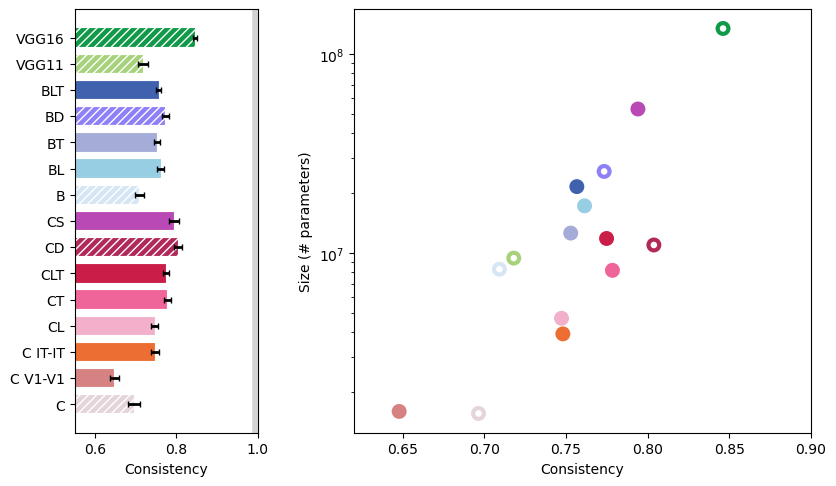

In [8]:
# First figure: model performance x size
fig, ax = plt.subplots(1, 2, figsize=(9.5, 5.5), gridspec_kw={'width_ratios': [2, 5]})

# Create the bar plot values
x_values = range(len(consistency_df))
y_values = consistency_df['acc mean']
# yerr = consistency_df['acc sem'] # For SEM
yerr = consistency_df['acc ci'] # For CI

# Left side of the plot - bars
bars = ax[0].barh(
    y=x_values,
    width=y_values,
    height=0.7,
    xerr = yerr,
    error_kw=err_bar_dict,
    color=[model_palette[m] for m in consistency_df['model']],
    linewidth=0.1,
    edgecolor='white',
    hatch=['' if model_architectures[m]=="recurrent" else '////' for m in consistency_df['model']],
)
# Change the axes
ax[0].set_xlim(0.55, 1.0)
ax[0].set_ylabel(None)
ax[0].set_xlabel('Consistency')
ax[0].set_yticks(ticks=x_values, labels=[model_names[m] for m in consistency_df['model']])
# Add a noise ceiling
ax[0].axvline(
    np.mean(consistency_reliability['across ppts']['accuracy']),
    color='lightGray',
    linewidth=4.0)

# Right part of the plot
ax[1].set_ylabel('Size (# parameters)')
ax[1].set_yscale('log')
ax[1].set_xlabel('Consistency')
ax[1].set_xlim(0.62, 0.87)
ax[1].set_xticks(ticks=ax[1].get_xticks()[1:])
# Make the scatter plot
ax[1].scatter(
    y = consistency_df['size'],
    x = y_values,
    color=[model_palette[m] if model_architectures[m]=="recurrent" else 'white' for m in consistency_df['model']],
    edgecolor=[model_palette[m] for m in consistency_df['model']],
    linewidth=3.0,
    s = marker_size*20
)
# Adjust the distance between plots
plt.subplots_adjust(wspace=0.3)

Reproduce figure 5c.

Text(0.5, 1.0, 'Masked trials')

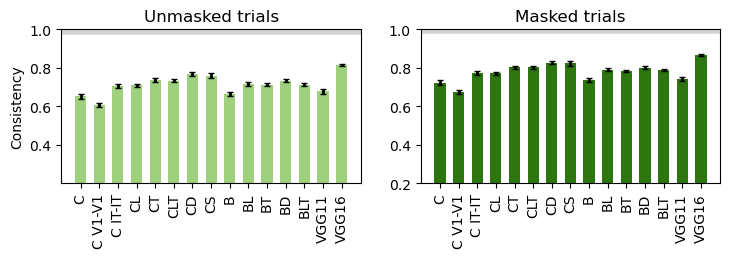

In [9]:
## Make two bar plots of average consistency, with and without mask

# Make the two plots next to one another
fig, ax = plt.subplots(1, 2, figsize=(8.5, 2.0))
bar_width = 0.6

# Left side of the plot - easy bars
ax[0].bar(x=range(len(consistency_df)), height=consistency_df['acc no mask mean'], width=bar_width,
          color=NOMASK_COLOUR, label='No mask', yerr = consistency_df['acc no mask ci'],
               error_kw= err_bar_dict)
# Add a noise ceiling
ax[0].axhline(
    np.mean(consistency_reliability['across ppts']['accuracy no mask']),
    color='lightGray',
    linewidth=4.0)
# Change the axes
ax[0].set_ylim(0.2, 1.0)
ax[0].set_yticks(ticks=ax[0].get_yticks()[1:])
ax[0].set_ylabel('Consistency')
ax[0].set_xticks(range(len(consistency_df)), labels=[model_names[m] for m in consistency_df['model']], rotation = 90)
# Add a title
ax[0].set_title('Unmasked trials')

# Right side of the plot - challenging bars
ax[1].bar(x=range(len(consistency_df)), height=consistency_df['acc mask mean'], width=bar_width, 
          color=MASK_COLOUR, label='Easy tasks', yerr = consistency_df['acc mask ci'],
               error_kw= err_bar_dict)
ax[1].axhline(
    np.mean(consistency_reliability['across ppts']['accuracy mask']),
    color='lightGray',
    linewidth=4.0)
# Change the axes
ax[1].set_ylim(0.2, 1.0)
ax[1].set_xticks(range(len(consistency_df)), labels=[model_names[m] for m in consistency_df['model']], rotation = 90)
# Add a title
ax[1].set_title('Masked trials')